In [1]:
from __future__ import annotations
from typing import TypedDict, List, Optional
import time

# ---- LangGraph / LangChain ----
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

from langchain_core.documents import Document
from langchain_openai import ChatOpenAI
from langchain_huggingface import HuggingFaceEmbeddings

# ---- FAISS vector stores ----
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

/Users/maruthienugula/RAG_learnings/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ================= CONFIG =================
EMBED_MODEL = "sentence-transformers/all-mpnet-base-v2"  # 768 dimensions
VECTOR_DIM = 768

LLM_MODEL = "groq:meta-llama/llama-4-scout-17b-16e-instruct"
LLM_TEMPERATURE = 0

RETRIEVE_TOP_K = 4
CACHE_TOP_K = 3

CACHE_DISTANCE_THRESHOLD = 0.45

# Optional TTL for cache entries (seconds). 0 = disabled.
CACHE_TTL_SEC = 0

In [4]:
# ================= STATE ==================
class RAGState(TypedDict):
    question: str
    normalized_question: str
    context_docs: List[Document]
    answer: Optional[str]
    citations: List[str]
    cache_hit: bool

In [5]:
# ============== GLOBALS ===================
from langchain_huggingface import HuggingFaceEmbeddings
EMBED = HuggingFaceEmbeddings(model_name=EMBED_MODEL)

In [6]:
# ----- QA CACHE (EMPTY, SAFE INIT) -----
qa_index = faiss.IndexFlatL2(VECTOR_DIM)  # distance; lower is better
QA_CACHE = FAISS(
    embedding_function=EMBED,
    index=qa_index,
    docstore=InMemoryDocstore({}),
    index_to_docstore_id={}
)

In [7]:
QA_CACHE

In [8]:
# ----- RAG STORE (demo only) -----
RAG_STORE = FAISS.from_texts(
    texts=[
        "LangGraph lets you compose stateful LLM workflows as graphs.",
        "In LangGraph, nodes can be cached; node caching memoizes outputs keyed by inputs for a TTL.",
        "Retrieval-Augmented Generation (RAG) retrieves external context and injects it into prompts.",
        "Semantic caching reuses prior answers when new questions are semantically similar."
    ],
    embedding=EMBED,
)

In [9]:
from langchain.chat_models import init_chat_model
LLM = init_chat_model(model=LLM_MODEL)


In [10]:
LLM.invoke("Hey")

AIMessage(content="Hey! How's it going? Is there something I can help you with, or do you just want to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 11, 'total_tokens': 36, 'completion_time': 0.05918213, 'completion_tokens_details': None, 'prompt_time': 5.1809e-05, 'prompt_tokens_details': None, 'queue_time': 0.044786675, 'total_time': 0.059233939}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c3ebe-57a5-7013-8aeb-5e89b05e152a-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 11, 'output_tokens': 25, 'total_tokens': 36})

In [11]:
# ================ NODES ===================
def normalize_query(state: RAGState) -> RAGState:
    q = (state["question"] or "").strip()
    state["normalized_question"] = q.lower()
    return state

def semantic_cache_lookup(state: RAGState) -> RAGState:
    q = state["normalized_question"]
    state["cache_hit"] = False  # default

    if not q:
        return state

    #  Guard: FAISS crashes if ntotal == 0 and you ask for k>0
    if getattr(QA_CACHE, "index", None) is None or QA_CACHE.index.ntotal == 0:
        return state

    # For FAISS L2 wrapper, this returns (Document, distance) with lower=better
    hits = QA_CACHE.similarity_search_with_score(q, k=CACHE_TOP_K)
    if not hits:
        return state

    best_doc, dist = hits[0]

    # Optional TTL
    if CACHE_TTL_SEC > 0:
        ts = best_doc.metadata.get("ts")
        if ts is None or (time.time() - float(ts)) > CACHE_TTL_SEC:
            return state

    # L2 distance gate (lower = more similar)
    if dist <= CACHE_DISTANCE_THRESHOLD:
        cached_answer = best_doc.metadata.get("answer")
        if cached_answer:
            state["answer"] = cached_answer
            state["citations"] = ["(cache)"]
            state["cache_hit"] = True

    return state

def respond_from_cache(state: RAGState) -> RAGState:
    return state

def retrieve(state: RAGState) -> RAGState:
    q = state["normalized_question"]
    docs = RAG_STORE.similarity_search(q, k=RETRIEVE_TOP_K)
    state["context_docs"] = docs
    return state

def generate(state: RAGState) -> RAGState:
    q = state["question"]
    docs = state.get("context_docs", [])
    ctx = "\n\n".join([f"[doc-{i}] {d.page_content}" for i, d in enumerate(docs, start=1)])

    system = (
        "You are a precise RAG assistant. Use the context when helpful. "
        "Cite with [doc-i] markers if you use a fact from the context."
    )
    user = f"Question: {q}\n\nContext:\n{ctx}\n\nWrite a concise answer with citations."

    resp = LLM.invoke([{"role": "system", "content": system},
                       {"role": "user", "content": user}])
    state["answer"] = resp.content
    state["citations"] = [f"[doc-{i}]" for i in range(1, len(docs) + 1)]
    return state

def cache_write(state: RAGState) -> RAGState:
    q = state["normalized_question"]
    a = state.get("answer")
    if not q or not a:
        return state

    QA_CACHE.add_texts(
        texts=[q],
        metadatas=[{
            "answer": a,
            "ts": time.time(),
        }]
    )
    return state

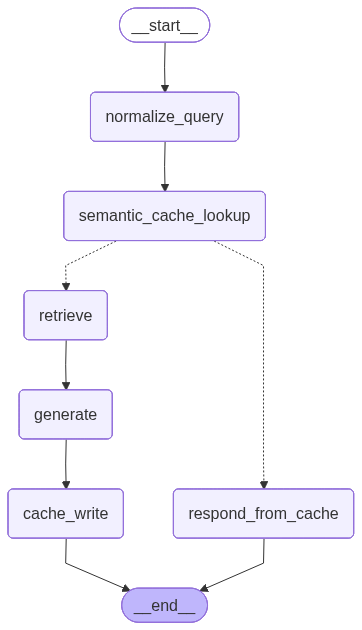

In [12]:
# ============== GRAPH WIRING ==============
graph = StateGraph(RAGState)

graph.add_node("normalize_query", normalize_query)
graph.add_node("semantic_cache_lookup", semantic_cache_lookup)
graph.add_node("respond_from_cache", respond_from_cache)
graph.add_node("retrieve", retrieve)
graph.add_node("generate", generate)
graph.add_node("cache_write", cache_write)

graph.set_entry_point("normalize_query")
graph.add_edge("normalize_query", "semantic_cache_lookup")

def _branch(state: RAGState) -> str:
    return "respond_from_cache" if state.get("cache_hit") else "retrieve"

graph.add_conditional_edges(
    "semantic_cache_lookup",
    _branch,
    {
        "respond_from_cache": "respond_from_cache",
        "retrieve": "retrieve"
    }
)

graph.add_edge("respond_from_cache", END)
graph.add_edge("retrieve", "generate")
graph.add_edge("generate", "cache_write")
graph.add_edge("cache_write", END)

memory = MemorySaver()
app = graph.compile(checkpointer=memory)
app

In [13]:
# ================= DEMO ===================
if __name__ == "__main__":
    thread_cfg = {"configurable": {"thread_id": "demo-user-1"}}

    q1 = "What is LangGraph ?"
    out1 = app.invoke({"question": q1, "context_docs": [], "citations": []}, thread_cfg)
    print("Answer:", out1["answer"])
    print("Citations:", out1.get("citations"))
    print("Cache hit?:", out1.get("cache_hit"))

Answer: LangGraph is a framework that allows composing stateful Large Language Model (LLM) workflows as graphs [doc-2]. It also features node caching, which memoizes outputs based on inputs for a specified time-to-live (TTL) [doc-1].
Citations: ['[doc-1]', '[doc-2]', '[doc-3]', '[doc-4]']
Cache hit?: False


In [14]:
q1 = "Explain about LangGraph ?"
out1 = app.invoke({"question": q1, "context_docs": [], "citations": []}, thread_cfg)
print("Answer:", out1["answer"])
print("Citations:", out1.get("citations"))
print("Cache hit?:", out1.get("cache_hit"))

Answer: LangGraph is a framework that allows composing stateful Large Language Model (LLM) workflows as graphs [doc-2]. It also features node caching, which memoizes outputs based on inputs for a specified time-to-live (TTL) [doc-1].
Citations: ['(cache)']
Cache hit?: True


In [15]:
q1 = "Explain about LangGraph agents ?"
out1 = app.invoke({"question": q1, "context_docs": [], "citations": []}, thread_cfg)
print("Answer:", out1["answer"])
print("Citations:", out1.get("citations"))
print("Cache hit?:", out1.get("cache_hit"))

Answer: LangGraph agents are part of a framework that allows composing stateful Large Language Model (LLM) workflows as graphs [doc-2]. In this context, nodes can be cached, which enables memoization of outputs based on inputs for a specified time-to-live (TTL) [doc-1]. This framework seems to be related to Retrieval-Augmented Generation (RAG) systems, which retrieve external context to enhance prompts [doc-3]. Additionally, LangGraph may incorporate features like semantic caching, which reuses previous answers for semantically similar new questions [doc-4]. However, specific details about "LangGraph agents" are not provided in the given context.
Citations: ['[doc-1]', '[doc-2]', '[doc-3]', '[doc-4]']
Cache hit?: False


In [16]:
q1 = "Explain about agents in Langgraph ?"
out1 = app.invoke({"question": q1, "context_docs": [], "citations": []}, thread_cfg)
print("Answer:", out1["answer"])
print("Citations:", out1.get("citations"))
print("Cache hit?:", out1.get("cache_hit"))

Answer: LangGraph agents are part of a framework that allows composing stateful Large Language Model (LLM) workflows as graphs [doc-2]. In this context, nodes can be cached, which enables memoization of outputs based on inputs for a specified time-to-live (TTL) [doc-1]. This framework seems to be related to Retrieval-Augmented Generation (RAG) systems, which retrieve external context to enhance prompts [doc-3]. Additionally, LangGraph may incorporate features like semantic caching, which reuses previous answers for semantically similar new questions [doc-4]. However, specific details about "LangGraph agents" are not provided in the given context.
Citations: ['(cache)']
Cache hit?: True
